In [19]:
import os
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans, vq
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.vq import kmeans2
from datetime import datetime, timezone

In [70]:
def convert_from_unit(time, units):
    if units == "seconds since 2008-03-01 00:00:00":
        return datetime.utcfromtimestamp(time + (datetime(2008, 3, 1).replace(tzinfo=timezone.utc) - datetime(1970, 1, 1).replace(tzinfo=timezone.utc)).total_seconds())
    elif units == "seconds since 1970-01-01 00:00:00":
        return datetime.utcfromtimestamp(float(time))
    elif units == "nano":
        return datetime.utcfromtimestamp(time / 1000000000)
    else:
        raise ValueError("Apologies unable to read NetCDF with time unit: {}".format(units))

In [21]:
def get_closest_index(value, array):
    array = np.asarray(array)
    sorted_array = np.sort(array)
    if len(array) == 0:
        raise ValueError("Array must be longer than len(0) to find index of value")
    elif len(array) == 1:
        return 0
    if value > (2 * sorted_array[-1] - sorted_array[-2]):
        raise HTTPException(status_code=400,
                            detail="Value {} greater than max available ({})".format(value, sorted_array[-1]))
    elif value < (2 * sorted_array[0] - sorted_array[-1]):
        raise HTTPException(status_code=400,
                            detail="Value {} less than min available ({})".format(value, sorted_array[0]))
    return (np.abs(array - value)).argmin()

In [22]:
def centroid_difference(data):
    k = 4
    centroids, _ = kmeans(data, k)
    cluster_labels, _ = vq(data, centroids)
    for i in range(k):
        cluster_points = data[cluster_labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')

    # Plot centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=100, label='Centroids')
    plt.legend()
    return np.linalg.norm(centroids[0] - centroids[1])

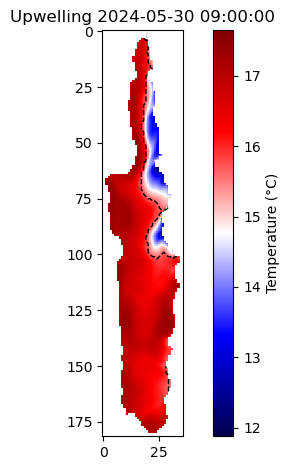

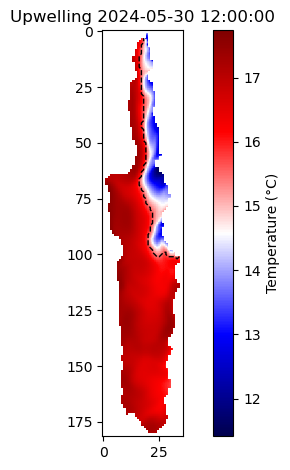

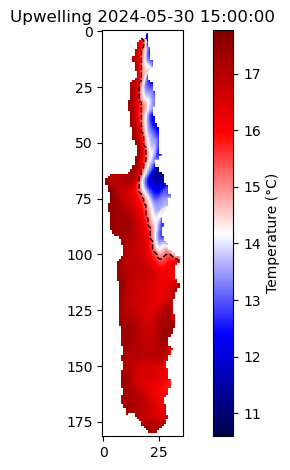

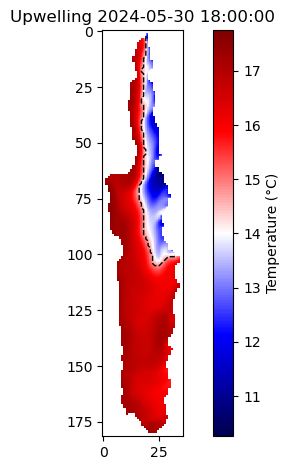

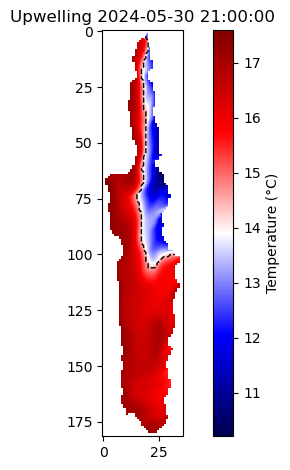

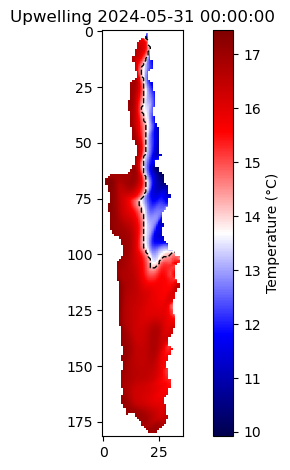

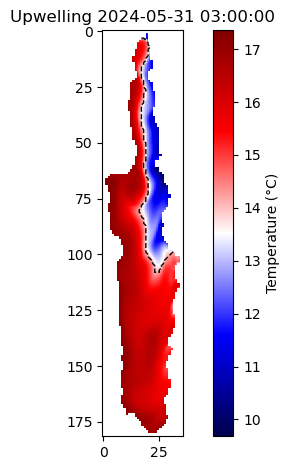

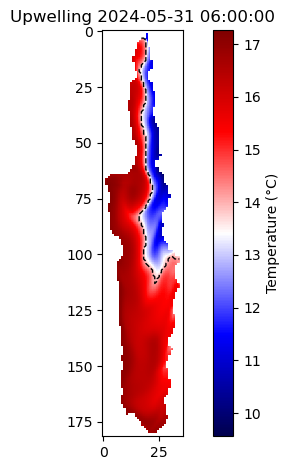

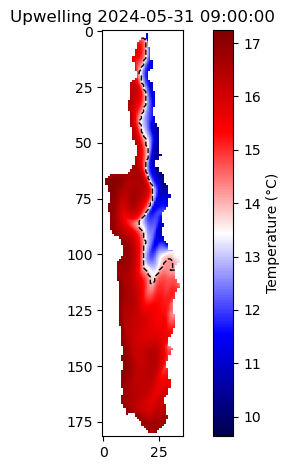

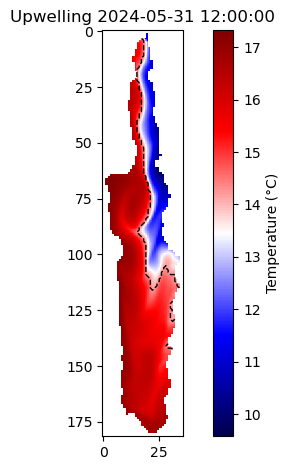

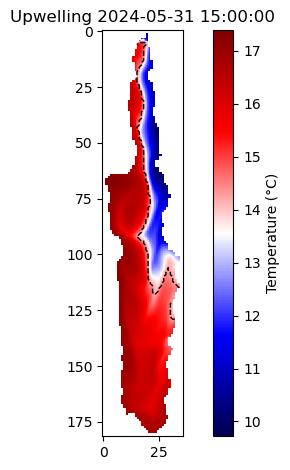

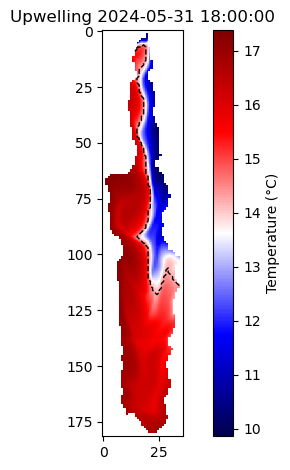

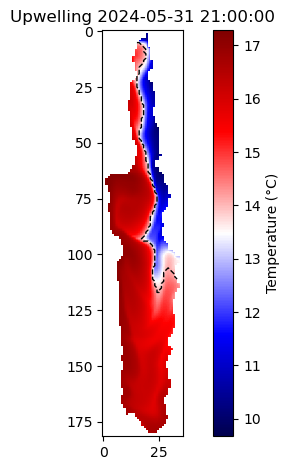

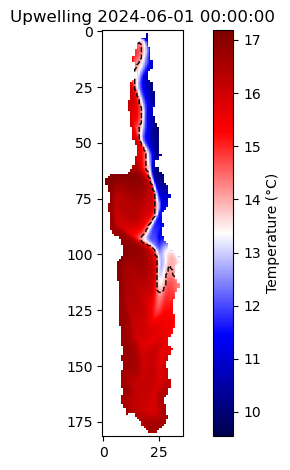

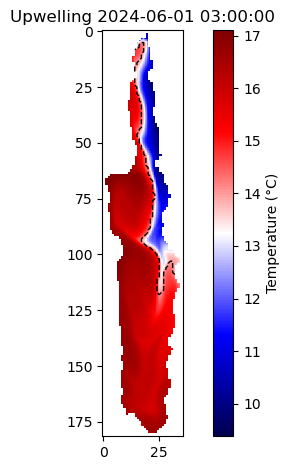

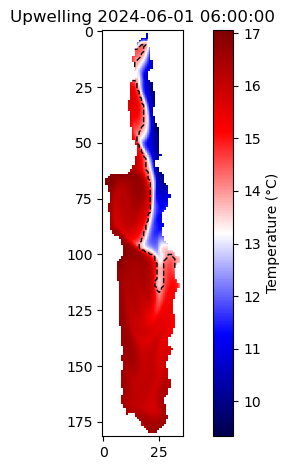

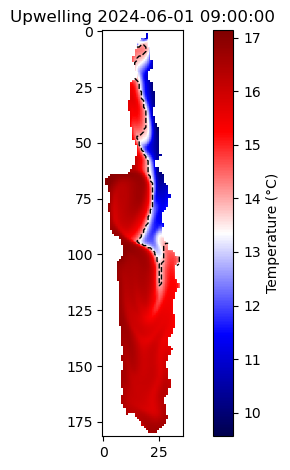

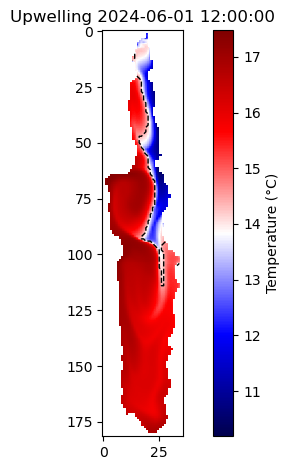

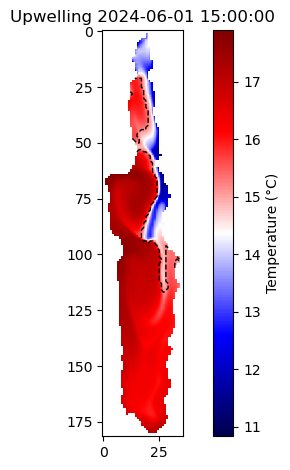

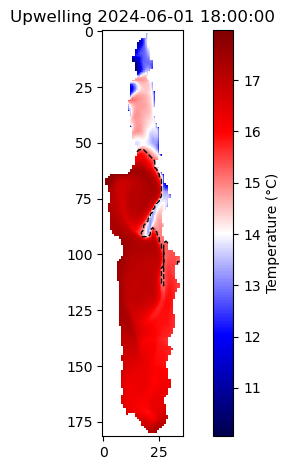

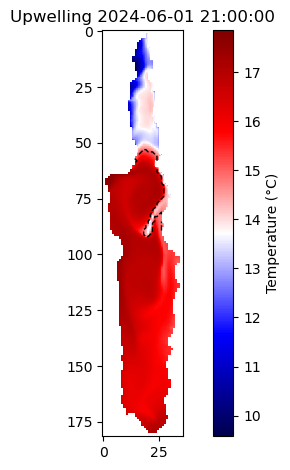

In [73]:
folder = "/home/runnalja/git/alplakes/simulations/runs/test"
depth = 1

with netCDF4.Dataset(os.path.join(folder, "delft3d-flow_geneva_20240526.nc")) as nc:
    depth_index = get_closest_index(depth, np.array(nc.variables["ZK_LYR"][:]) * -1)
    time = [convert_from_unit(t, nc.variables["time"].units) for t in nc.variables["time"][:]]
        
    for time_index in range(len(nc.variables["time"])):    
        values = np.array(nc.variables["R1"][time_index, 0, depth_index, :]).flatten()
        mask = values != -999
        data = values[mask]   

        k = 2
        centroids, _ = kmeans(data, k)
        cluster_labels, _ = vq(data, centroids)
        
        if abs(centroids[1] - centroids[0]) > 2:
            plot_values = np.array(nc.variables["R1"][time_index, 0, depth_index, :])
            plot_values[plot_values == -999] = np.nan
            plt.imshow(plot_values, cmap='seismic')
            plt.colorbar(label="Temperature (°C)")
            plt.title("Upwelling {}".format(time[time_index]))
            plt.tight_layout()
            out = np.zeros(len(values))
            out[:] = np.nan
            out[mask] = cluster_labels
            out = out.reshape(plot_values.shape)    
            plt.contour(list(range(out.shape[1])), list(range(out.shape[0])), out, levels=[0,1], colors='k', linewidths=1, linestyles='dashed')
            
            plt.show()

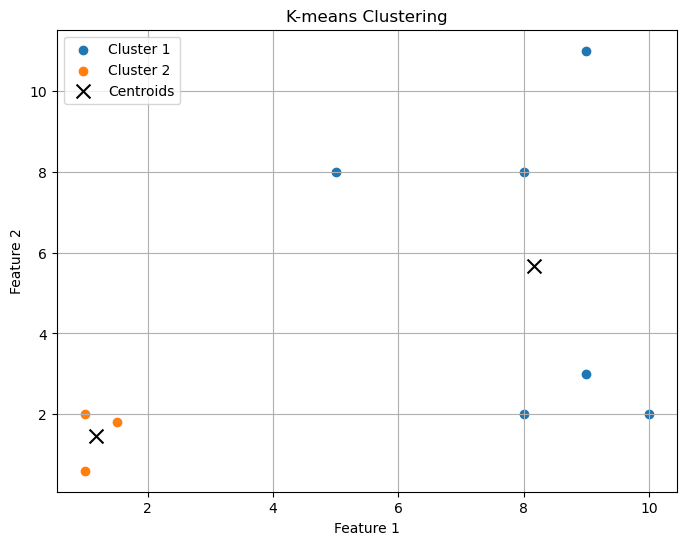

In [50]:
# Sample data: 2D matrix where each row is a data point
data = np.array([[1.0, 2.0],
                 [1.5, 1.8],
                 [5.0, 8.0],
                 [8.0, 8.0],
                 [1.0, 0.6],
                 [9.0, 11.0],
                 [8.0, 2.0],
                 [10.0, 2.0],
                 [9.0, 3.0]])

# Number of clusters
k = 2

# Perform K-means clustering
centroids, _ = kmeans(data, k)

# Assign each data point to a cluster
cluster_labels, _ = vq(data, centroids)

# Create a plot where each cluster is represented by a block color
plt.figure(figsize=(8, 6))

# Plot each cluster
for i in range(k):
    cluster_points = data[cluster_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=100, label='Centroids')

plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
nc.variables["time"][:]

RuntimeError: NetCDF: Not a valid ID

In [1]:
start_time = functions.convert_to_unit(start_datetime, nc.variables["time"].units)

NameError: name 'functions' is not defined

In [14]:
from datetime import datetime

# Define the two dates
date1 = datetime(2024, 5, 31, 23, 0, 0)
date2 = datetime(2008, 3, 1, 0, 0, 0)

# Calculate the difference in seconds
difference_in_seconds = (date1 - date2).total_seconds()
difference_in_seconds

512866800.0

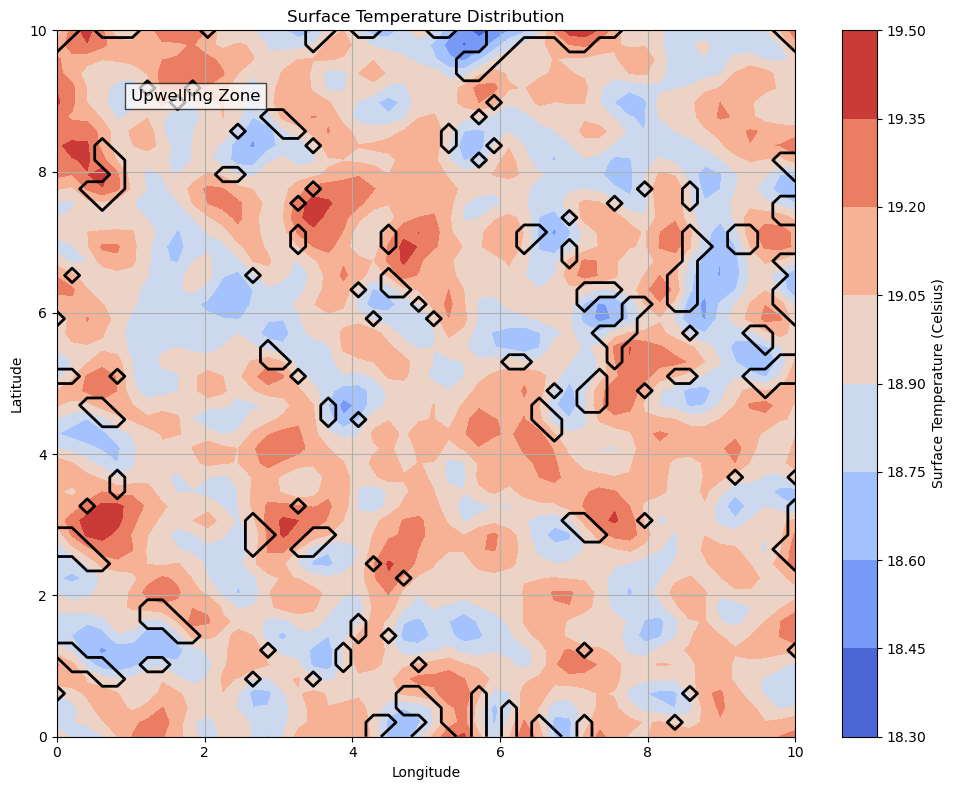

Upwelling zones detected.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Example data: surface temperature distribution (replace with your actual simulation data)
# Assuming a 2D grid for simplicity
# Replace with your actual data or generate a sample dataset
lon = np.linspace(0, 10, 50)  # Longitude
lat = np.linspace(0, 10, 50)  # Latitude
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Generate example surface temperature data
temperature = np.random.uniform(18.0, 20.0, size=(50, 50))

# Smooth the temperature field to reduce noise
temperature_smoothed = gaussian_filter(temperature, sigma=1)

# Calculate horizontal gradients using central differences
grad_x, grad_y = np.gradient(temperature_smoothed, lon, lat)

# Define a threshold for gradient magnitude to detect upwelling
gradient_threshold = 1  # Example threshold (adjust as per your data characteristics)

# Detect upwelling zones based on gradient magnitude
upwelling_mask = np.sqrt(grad_x**2 + grad_y**2) > gradient_threshold

# Plotting for visualization
plt.figure(figsize=(10, 8))

# Plot surface temperature
plt.contourf(lon_grid, lat_grid, temperature_smoothed, cmap='coolwarm')
plt.colorbar(label='Surface Temperature (Celsius)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Surface Temperature Distribution')

# Overlay upwelling zones
plt.contour(lon_grid, lat_grid, upwelling_mask, levels=[0.5], colors='k', linewidths=2)
plt.text(1, 9, 'Upwelling Zone', color='k', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

plt.grid(True)
plt.tight_layout()
plt.show()

# Output upwelling information
if np.any(upwelling_mask):
    print("Upwelling zones detected.")
else:
    print("No upwelling zones detected in this temperature distribution.")

/home/runnalja/anaconda3/envs/airflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


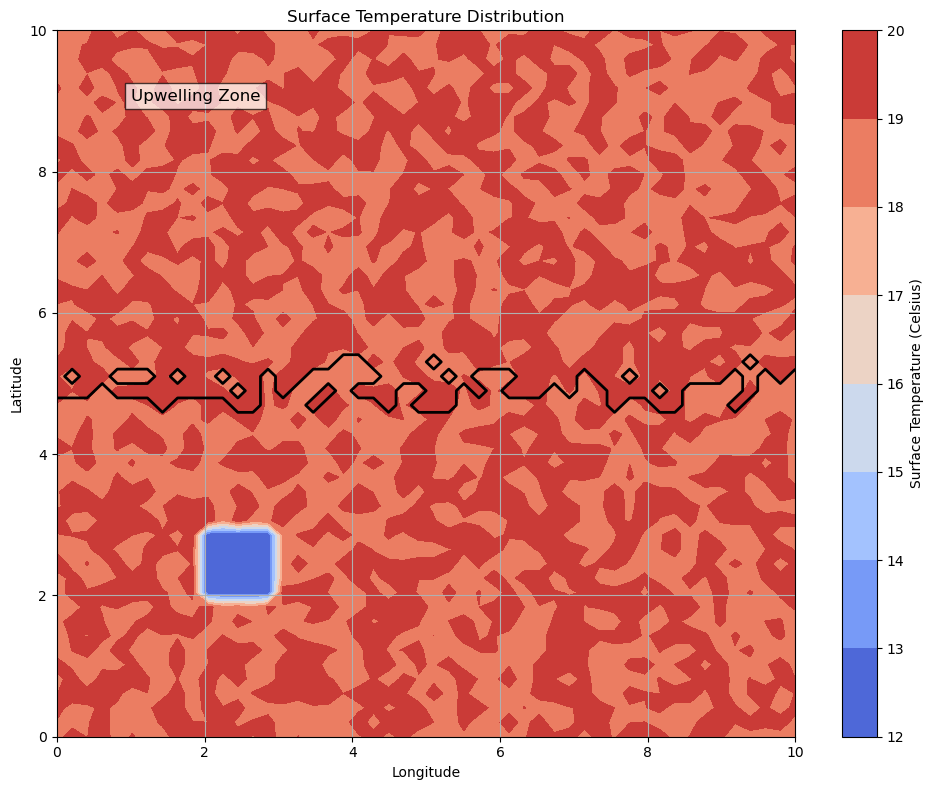

Upwelling zones detected.


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Example data: surface temperature distribution (replace with your actual simulation data)
# Assuming a 2D grid for simplicity
# Replace with your actual data or generate a sample dataset
lon = np.linspace(0, 10, 50)  # Longitude
lat = np.linspace(0, 10, 50)  # Latitude
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Generate example surface temperature data
temperature = np.random.uniform(18.0, 20.0, size=(50, 50))
temperature[10:15, 10:15] = 12

# Reshape data for clustering
X = np.column_stack((lon_grid.ravel(), lat_grid.ravel(), temperature.ravel()))

# Normalize data (optional but often recommended for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(X_scaled)

# Reshape cluster results back to 2D grid
clustered_grid = clusters.reshape(lon_grid.shape)

# Plotting for visualization
plt.figure(figsize=(10, 8))

# Plot surface temperature
plt.contourf(lon_grid, lat_grid, temperature, cmap='coolwarm')
plt.colorbar(label='Surface Temperature (Celsius)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Surface Temperature Distribution')

# Overlay clustering results (upwelling zones)
plt.contour(lon_grid, lat_grid, clustered_grid, levels=[0.5], colors='k', linewidths=2)
plt.text(1, 9, 'Upwelling Zone', color='k', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

plt.grid(True)
plt.tight_layout()
plt.show()

# Output upwelling information
if np.any(clustered_grid == 0):
    print("Upwelling zones detected.")
else:
    print("No upwelling zones detected in this temperature distribution.")

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Example 1D dataset (replace with your actual data)
np.random.seed(0)
data = np.random.normal(loc=[2, 8], scale=[1, 1], size=100).reshape(-1, 1)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(data)

# Plotting for visualization
plt.figure(figsize=(8, 6))

# Plot the data points
plt.scatter(data, np.zeros_like(data), c=clusters, cmap='viridis', marker='o', s=50, alpha=0.6)

# Plot the cluster centers
plt.scatter(kmeans.cluster_centers_, np.zeros_like(kmeans.cluster_centers_), marker='x', color='red', s=100, label='Cluster Centers')

plt.xlabel('Data')
plt.title('KMeans Clustering on 1D Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Output cluster information
cluster_counts = np.bincount(clusters)
print(f"Cluster 0 has {cluster_counts[0]} points")
print(f"Cluster 1 has {cluster_counts[1]} points")

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (100,) and arg 1 with shape (2,).